In [1]:
import json
import os
import sys
import numpy as np
from gensim.models import Word2Vec
# from keras.preprocessing import sequence
# from keras.layers import merge, Dense, Input,Dropout, Embedding, LSTM, Bidirectional, Activation
# from keras.layers import Conv2D,Conv1D
# from keras.layers.merge import dot, multiply, add, concatenate
# from keras.layers import Merge
# from keras.layers.core import Lambda,Reshape, Flatten, Dropout
# from keras.layers.pooling import GlobalMaxPooling2D, GlobalMaxPooling1D,MaxPooling1D
# from keras.models import Model
# from keras.backend import transpose,batch_dot,expand_dims
# from keras import optimizers
from HomeDepotCSVReader import HomeDepotReader
import Utilities
from DataPreprocessing import DataPreprocessing
from Feature_Word2Vec import Feature_Word2Vec
from AutomaticQueryExpansion import Word2VecQueryExpansion
import re
from nltk.corpus import stopwords
# from keras.utils.np_utils import to_categorical
import pandas as pd
from FeatureEngineering import HomeDepotFeature
# from keras.layers.wrappers import TimeDistributed
# from keras.callbacks import ModelCheckpoint,EarlyStopping

In [2]:
# train_filename = '../data/train_play.csv'
# test_filename = '../data/test_play.csv'
# soln_filename = '../data/solution.csv'
# attribute_filename = '../data/attributes_play.csv'
# description_filename = '../data/product_descriptions_play.csv'
# word2vec_model_path='model/word2vec_play.model'
# doc2vec_model_path='model/doc2vec_play.model'
# vocab_path='model/word2vec_play_vocab.json'
# embeddings_path='model/embeddings_play.npz'

train_filename = '../data/train.csv'
test_filename = '../data/test.csv'
soln_filename = '../data/solution.csv'
attribute_filename = '../data/attributes.csv'
description_filename = '../data/product_descriptions.csv'
word2vec_model_path='model/word2vec_sense2vec_all.model'
doc2vec_model_path='model/doc2vec_sense2vec_noun.model'
vocab_path='model/doc2vec_sense2vec_vocab_all.json'
embeddings_path='model/embeddings_sense2vec_all.npz'
full_features_filename = '../data/features_full_plusnouns_pluspuidthresh.csv'

In [3]:
reader = HomeDepotReader()

train_query_df, product_df, attribute_df, test_query_df = reader.getQueryProductAttributeDataFrame(train_filename,
                                              test_filename,
                                              attribute_filename,
                                              description_filename)
print("train_query_df:",list(train_query_df))
print("product_df:", list(product_df))
print("attribute_df:", list(attribute_df))
print("test_query_df:", list(test_query_df))

#transform attribute into doc
dp = DataPreprocessing()
attribute_doc_df = dp.getAttributeDoc(attribute_df)
#attribute_doc_df
product_df=product_df.join(attribute_doc_df.set_index('product_uid'), on = 'product_uid')
### test data
soln_df = pd.read_csv(soln_filename, delimiter=',', low_memory=False, encoding="ISO-8859-1")
test_private_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Private')#,savepath='../data/test_private_gold.csv')
test_public_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Public')# savepath='../data/test_public_gold.csv')

===========Tranforming labels...
showing current values
trainDF: ['id', 'product_uid', 'search_term', 'relevance']
trainDF:    id  product_uid    search_term  relevance
0   2       100001  angle bracket        3.0
self.mergedLabelDF: ['relevance'] 
 <class 'pandas.core.frame.DataFrame'> (74067, 1)    relevance
0        3.0
Old unique Labels: [ 1.    1.25  1.33  1.5   1.67  1.75  2.    2.25  2.33  2.5   2.67  2.75
  3.  ]
newLabels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Creating new column for training:  relevance_int
===========Transform labels completed
train_query_df: ['id', 'product_uid', 'search_term', 'relevance', 'relevance_int', 'product_idx']
product_df: ['product_title', 'product_uid', 'product_description']
attribute_df: ['product_uid', 'name', 'value']
test_query_df: ['id', 'product_uid', 'search_term', 'product_idx']


In [4]:
product_df

,product_title,product_uid,product_description,attr_json
0,Simpson Strong-Tie 12-Gauge Angle,100001,"Not only do angles make joints stronger, they ...",{'Bullet01': 'Versatile connector for various ...
1,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,BEHR Premium Textured DECKOVER is an innovativ...,"{'Application Method': 'Brush,Roller,Spray', '..."
2,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,Update your bathroom with the Delta Vero Singl...,"{'Bath Faucet Type': 'Combo Tub and Shower', '..."
3,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,Achieving delicious results is almost effortle...,"{'Appliance Type': 'Over the Range Microwave',..."
4,Lithonia Lighting Quantum 2-Light Black LED Em...,100007,The Quantum Adjustable 2-Light LED Black Emerg...,"{'Battery Power Type': 'Ni-Cad', 'Battery Size..."
5,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,100009,Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...,"{'Application': 'Door & Window', 'Bullet01': '..."
6,Valley View Industries Metal Stakes (4-Pack),100010,Valley View Industries Metal Stakes (4-Pack) a...,"{'Attachable': 'No', 'Bullet01': 'Can be used ..."
7,Toro Personal Pace Recycler 22 in. Variable Sp...,100011,Recycler 22 in. Personal Pace Variable Speed S...,"{'Assembled Depth (in.)': '59 in', 'Assembled ..."
8,Hampton Bay Caramel Simple Weave Bamboo Rollup...,100012,The 96 in. wide Caramel Simple Weave Rollup Ba...,"{'Actual Blind/Shade Width (In.)': '96', 'Arch..."
9,InSinkErator SinkTop Switch Single Outlet for ...,100013,The InSinkErator SinkTop Switch Single Outlet ...,"{'Bullet01': 'Kit includes satin nickel, chrom..."


In [5]:
train_query_df,product_df, attribute_df = HomeDepotFeature().getFeature(train_query_df, product_df, attribute_df, test_private_df,
                        features="spelling,nonascii,brand")

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.01 minutes
Non-ascii clean on product_title took: 0.03 minutes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 6 columns):
id               74067 non-null int64
product_uid      74067 non-null int64
search_term      74067 non-null object
relevance        74067 non-null float64
relevance_int    74067 non-null int64
product_idx      74067 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ MB
train_query_df final column:
 None


In [6]:
test_query_df,_, _ = HomeDepotFeature().getFeature(test_query_df, product_df, attribute_df, test_private_df,
                        features="spelling,nonascii")

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.01 minutes
Non-ascii clean on product_title took: 0.04 minutes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 4 columns):
id             166693 non-null int64
product_uid    166693 non-null int64
search_term    166693 non-null object
product_idx    166693 non-null object
dtypes: int64(2), object(2)
memory usage: 5.1+ MB
train_query_df final column:
 None


In [7]:
product_df

,product_title,product_uid,product_description,attr_json,product_brand
0,Simpson Strong Tie 12 Gauge Angle,100001,Not only do angles make joints stronger they a...,'Bullet01' 'Versatile connector for various 90...,Simpson Strong-Tie
1,BEHR Premium Textured deck over 1 gal SC 141 T...,100002,BEHR Premium Textured deck over is an innovati...,'Application Method' 'Brush Roller Spray' 'Ass...,BEHR Premium Textured DeckOver
2,Delta verso 1 Handle Shower Only Faucet Trim K...,100005,Update your bathroom with the Delta verso Sing...,'Bath Faucet Type' 'Combo Tub and Shower' 'Bui...,Delta
3,Whirlpool 1 9 cu. ft. Over the Range Convectio...,100006,Achieving delicious results is almost effortle...,'Appliance Type' 'Over the Range Microwave' 'A...,Whirlpool
4,lithograph Lighting Quantum 2 Light Black LED ...,100007,The Quantum Adjustable 2 Light LED Black Emerg...,'Battery Power Type' 'Ni Cad' 'Battery Size' '...,Lithonia Lighting
5,House of Fara 3 4 in. x 3 in. x 8 ft. MDF Flut...,100009,Get the House of Fara 3 4 in. x 3 in. x 8 ft. ...,'Application' 'Door Window' 'Bullet01' 'Made o...,House of Fara
6,Valley View Industries Metal Stakes 4 Pack,100010,Valley View Industries Metal Stakes 4 Pack are...,'Attachable' 'No' 'Bullet01' 'Can be used with...,Valley View Industries
7,Toro Personal Pace re cycler 22 in. Variable S...,100011,re cycler 22 in. Personal Pace Variable Speed ...,'Assembled Depth in. ' '59 in' 'Assembled Heig...,Toro
8,Hampton Bay Caramel Simple Weave Bamboo roll u...,100012,The 96 in. wide Caramel Simple Weave roll up B...,'Actual Blind Shade Width In. ' '96' 'Arched' ...,Hampton Bay
9,insinuator sink top Switch Single Outlet for i...,100013,The insinuator sink top Switch Single Outlet f...,'Bullet01' 'Kit includes satin nickel chrome a...,InSinkErator


In [8]:
# ## no attribute
product_df['content'] = product_df['product_title'].map(str) + ". " + \
                        product_df['product_description'].map(str) 
    
    


In [9]:
product_df['content_brand'] = product_df['product_brand']+ ". " + \
                        product_df['product_title'].map(str) + ". " + \
                        product_df['product_description'].map(str)

In [10]:
# attribute
product_df['content_attr'] = product_df['product_title'].map(str) + ". " + \
                            product_df['attr_json'].map(str)
# product_df['product_brand']+ ". " + \
#                        
#                         product_df['product_description'].map(str)  + ". " + \
                        

# resample

In [12]:
# #resample remove the low classes
# resampled_train_query_df = train_query_df[train_query_df.relevance_int == 0]
# min_samples=len(resampled_train_query_df)
# for i in range(1,13):
#     print(i)
#     tmp_df = train_query_df[train_query_df.relevance_int == i]
#     if len(tmp_df) > min_samples:
#         tmp_df = tmp_df.ix[np.random.choice(tmp_df.index,min_samples)]
#         resampled_train_query_df=pd.concat([resampled_train_query_df,tmp_df])

#     else:
#         print("removing {} as too few values {}".format(i,len(tmp_df)))
        
# ori_train_query_df=train_query_df        
# train_query_df=resampled_train_query_df

In [13]:
#don't sample
#train_query_df=ori_train_query_df


In [14]:
#### merge test and train queries for training
orig_train_query_df = train_query_df
train_query_df = pd.concat([train_query_df,test_query_df])


In [15]:
len(train_query_df)

240760

# end resample

In [16]:
import spacy
import re
#import sense2vec

In [17]:
LABELS = {
    'ENT': 'ENT',
    'PERSON': 'ENT',
    'NORP': 'ENT',
    'FAC': 'ENT',
    'ORG': 'ENT',
    'GPE': 'ENT',
    'LOC': 'ENT',
    'LAW': 'ENT',
    'PRODUCT': 'ENT',
    'EVENT': 'ENT',
    'WORK_OF_ART': 'ENT',
    'LANGUAGE': 'ENT',
    'DATE': 'DATE',
    'TIME': 'TIME',
    'PERCENT': 'PERCENT',
    'MONEY': 'MONEY',
    'QUANTITY': 'QUANTITY',
    'ORDINAL': 'ORDINAL',
    'CARDINAL': 'CARDINAL',
}


In [18]:
#pre_format_re = re.compile(r'^[\`\*\~]')
#post_format_re = re.compile(r'[\`\*\~]$')
#url_re = re.compile(r'\[([^]]+)\]\(%%URL\)')
#link_re = re.compile(r'\[([^]]+)\]\(https?://[^\)]+\)')
comma_num_re = re.compile(r'([0-9])(?:,)([0-9])') #Removed commas between digits (for example, 10, 000 was replaced with 10000)
digit_letter_re = re.compile(r'([0-9])([A-Za-z])') #Added dot and space between a digit (left) and a letter (right).
letters_digit_re = re.compile(r'([A-Za-z]){3}([0-9])') #Added space between at least three letters (left) and a digit (right).
letters_slash_re = re.compile(r'([A-Za-z])(?:[\\\/])([A-Za-z])') #Replaced \ or / between letters with a space.
camel_case_re = re.compile(r'([a-z])([A-Z])')
def strip_meta(text,titletext=''):
    #text = link_re.sub(r'\1', text)
    #Concatenation of Numbers with Measure Units
    text = re.sub('(?<=[0-9])[\ ]*pound[s]*(?=\ |$|\.)', '-lb ', text)
    text = re.sub('(?<=[0-9])[\ ]*lb[s]*(?=\ |$|\.)', '-lb ', text)
    text = re.sub('(?<=[0-9])[\ ]*gallon[s]*(?=\ |$|\.)', '-gal ', text)
    text = re.sub('(?<=[0-9])[\ ]*gal(?=\ |$|\.)', '-gal ', text)
    
    text = text.replace('&gt;', '>').replace('&lt;', '<').replace('&nbsp;',' ').\
            replace('&amp;','&').replace(';','.').replace(':','.').\
            replace('+',' ').replace('*','x').replace('(','.').replace(')','.')
    text = comma_num_re.sub(r'\1\2',text)    
    text = digit_letter_re.sub(r'\1. \2',text)    
    text = letters_digit_re.sub(r'\1 \2',text)  
    text = letters_slash_re.sub(r'\1 \2',text)
    if titletext:
        for word in text.split(): 
            #print(word)
            if camel_case_re.findall(word) and word not in titletext.split():  
                word_replace = camel_case_re.sub(r'\1 \2',word)
                text=re.compile(word).sub(word_replace,text)
                #print('here')
    #text = pre_format_re.sub('', text)
    #text = post_format_re.sub('', text)
    return text

In [19]:
strip_meta('asd/sd afj\sjk asasd1100b000 hotDog 10 pounds InSinkErator','InSinkErator asd ads asd')

'asd sd afj sjk asd 1100. b000 hot Dog 10-lb  InSinkErator'

In [20]:
train_query_df['search_term'] = train_query_df['search_term'].map(lambda x: strip_meta(x))
train_query_df['search_term']

0                              angle bracket
1                                  l bracket
2                                  deck over
3                           rain shower head
4                         shower only faucet
5                             convection otr
6                       microwave over stove
7                                 microwaves
8                            emergency light
9                                    mdf 3 4
10                               steel stake
11            briggs and stratton lawn mower
12                                 gas mower
13                               honda mower
14        hampton bay chestnut pull up shade
15                                  disposer
16                              grill gazebo
17                               door guards
18                    metal plate cover gcfi
19                            radiator grate
20                           windows screens
21                1. x1 rail decorative wood
22        

In [21]:
product_df['content_attr']=product_df.apply(lambda x: strip_meta(text=x['content_attr'],titletext=x['product_title']),axis=1)
product_df['content_attr']

0         Simpson Strong Tie 12 Gauge Angle. 'Bult 01' '...
1         BEHR Premium Textured deck over 1-gal  SC 141 ...
2         Delta verso 1 Handle Shower Only Faucet Trim K...
3         Whirlpool 1 9 cu. ft. Over the Range Convectio...
4         lithograph Lighting Quantum 2 Light Black LED ...
5         House of Fara 3 4 in. x 3 in. x 8 ft. MDF Flut...
6         Valley View Industries Metal Stakes 4 Pack. 'A...
7         Toro Personal Pace re cycler 22 in. Variable S...
8         Hampton Bay Caramel Simple Weave Bamboo roll u...
9         insinuator sink top Switch Single Outlet for i...
10        sun joy Calais 8 ft. x 5 ft. x 8 ft. Steel Til...
11        MD Building Products 36 in. x 36 in. Cloverlea...
12        House of Fara 8 Linear ft. MDF Overlapping Wai...
13        1804 Dual Spray Half Pattern 4 in Pop Up Spray...
14        sam sung 4 2 cu. ft. Front Load Washer with St...
15        Quikrete 80-lb . Crack Resistant Concrete. 'Bu...
16        Nantucket Pavers Patio on a Pa

In [22]:
product_df['content_attr']=product_df.apply(lambda x: strip_meta(text=x['content_attr'],titletext=x['product_title']),axis=1)
product_df['content_attr']

0         Simpson Strong Tie 12 Gauge Angle. 'Bult 01' '...
1         BEHR Premium Textured deck over 1-gal  SC 141 ...
2         Delta verso 1 Handle Shower Only Faucet Trim K...
3         Whirlpool 1 9 cu. ft. Over the Range Convectio...
4         lithograph Lighting Quantum 2 Light Black LED ...
5         House of Fara 3 4 in. x 3 in. x 8 ft. MDF Flut...
6         Valley View Industries Metal Stakes 4 Pack. 'A...
7         Toro Personal Pace re cycler 22 in. Variable S...
8         Hampton Bay Caramel Simple Weave Bamboo roll u...
9         insinuator sink top Switch Single Outlet for i...
10        sun joy Calais 8 ft. x 5 ft. x 8 ft. Steel Til...
11        MD Building Products 36 in. x 36 in. Cloverlea...
12        House of Fara 8 Linear ft. MDF Overlapping Wai...
13        1804 Dual Spray Half Pattern 4 in Pop Up Spray...
14        sam sung 4 2 cu. ft. Front Load Washer with St...
15        Quikrete 80-lb . Crack Resistant Concrete. 'Bu...
16        Nantucket Pavers Patio on a Pa

# transform

In [23]:
import spacy
#nlp = spacy.load('en')
#import en_vectors_glove_md
#nlp = en_vectors_glove_md.load()

nlp = spacy.load('en_core_web_md')

In [24]:
sentence='BEHR_Premium_Textured_deck|NOUN over|ADP 1-gal|VERB SC|NOUN 141|CARDINAL Tugboat_Wood|ENT'
keep_tags=['NOUN','PROPN','ENT','NUM','DATE','TIME','PERCENT','MONEY','QUANTITY','ORDINAL','CARDINAL']
#a=re.compile('^(\|'+'|'.join(keep_tags)+')')
keep_tags_re=re.compile('((?:[A-Za-z0-9_]+?\|)(?:NOUN|PROPN|ENT|NUM|DATE|TIME|PERCENT|MONEY|QUANTITY|ORDINAL|CARDINAL))')
print(sentence)
print(' '.join(keep_tags_re.findall(sentence)))

BEHR_Premium_Textured_deck|NOUN over|ADP 1-gal|VERB SC|NOUN 141|CARDINAL Tugboat_Wood|ENT
BEHR_Premium_Textured_deck|NOUN SC|NOUN 141|CARDINAL Tugboat_Wood|ENT


In [25]:
def represent_word(word):
    if word.like_url:
        return '%%URL|X'
    text = re.sub(r'\s', '_', word.text)
    tag = LABELS.get(word.ent_type_, word.pos_)
    if not tag:
        tag = '?'
    return text + '|' + tag

keep_tags_re=re.compile('((?:[A-Za-z0-9_]+?\|)(?:NOUN|PROPN|ENT|NUM|DATE|TIME|PERCENT|MONEY|QUANTITY|ORDINAL|CARDINAL))')
def transform_doc(doc,filter_pos=False):
    for ent in doc.ents:
        ent.merge(ent.root.tag_, ent.text, LABELS[ent.label_])
    for np in doc.noun_chunks:
        while len(np) > 1 and np[0].dep_ not in ('advmod', 'amod', 'compound'):
            np = np[1:]
        np.merge(np.root.tag_, np.text, np.root.ent_type_)
    strings = []
    for sent in doc.sents:
        if sent.text.strip():         
            if filter_pos == True:
                s = ' '.join(represent_word(w) for w in sent if not w.is_space)
                strings.append(' '.join(keep_tags_re.findall(s)))
            else:
                strings.append(' '.join(represent_word(w) for w in sent if not w.is_space))
    if strings:
        return '\n'.join(strings) + '\n'
    else:
        return ''

In [26]:
import time
from Utilities import Utility
#timetracker=Utility()

i=0
for row in product_df.itertuples():
    #timetracker.startTimeTrack()
    #start_time = time.time()
    print(row.content_attr)
    print("=========")
    doc=nlp(row.content_attr)
    print(transform_doc(doc,filter_pos=False))
    i+=1
    #timetracker.checkpointTimeTrack()
    #print("%s s" % round(((time.time() - start_time) ), 2))
    if i > 1:
        break

# product_df['sense2vec_content_attr']=product_df.apply(lambda x: transform_doc(nlp(x['content_attr'])),axis=1)
# product_df['sense2vec_content_attr']

Simpson Strong Tie 12 Gauge Angle. 'Bult 01' 'Versatile connector for various 90 connections and home repair projects' 'Bult 02' 'Stronger than angled nailing or screw fastening alone' 'Bult 03' 'Help ensure joints are consistently straight and strong' 'Bult 04' 'Dimensions 3 in. x 3 in. x 1 1 2 in. ' 'Bult 05' 'Made from 12 Gauge steel' 'Bult 06' 'Galvanized for extra corrosion resistance' 'Bult 07' 'Install with 10. d common nails or 9 x 1 1 2 in. Strong Drive SD screws' 'Gauge' '12' 'Material' 'Galvanized Steel' 'MFG Brand Name' 'Simpson Strong Tie' 'Number of Pieces' '1' 'Product Depth in. ' '1 5' 'Product Height in. ' '3' 'Product Weight lb. ' '0 26' 'Product Width in. ' '3'
Simpson_Strong_Tie|ENT 12|NUM Gauge_Angle|PROPN .|PUNCT '|PUNCT
Bult|VERB 01|NUM '|PUNCT '|PUNCT Versatile_connector|NOUN for|ADP various_90_connections|NOUN and|CCONJ home_repair_projects|NOUN '|PART '|PUNCT Bult|PROPN 02|NUM '|PUNCT '|PUNCT
Stronger|ADJ than|ADP angled|VERB nailing|VERB or|CCONJ screw|VERB f

In [27]:
from joblib import Parallel, delayed
import multiprocessing
    
# what are your inputs, and what operation do you want to 
# perform on each input. For example...
def processInput(i):
    return transform_doc(nlp(i),filter_pos=False)

num_cores = multiprocessing.cpu_count()
    
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i.content_attr) for i in product_df.itertuples())

In [28]:
sense2vec_content_attr_df=pd.DataFrame(results,columns=['sense2vec_content_attr'])
product_df=pd.concat([product_df,sense2vec_content_attr_df],axis=1)

In [29]:
product_df['sense2vec_content_attr'][0]

"Simpson_Strong_Tie|ENT 12|NUM Gauge_Angle|PROPN .|PUNCT '|PUNCT\nBult|VERB 01|NUM '|PUNCT '|PUNCT Versatile_connector|NOUN for|ADP various_90_connections|NOUN and|CCONJ home_repair_projects|NOUN '|PART '|PUNCT Bult|PROPN 02|NUM '|PUNCT '|PUNCT\nStronger|ADJ than|ADP angled|VERB nailing|VERB or|CCONJ screw|VERB fastening|VERB alone|ADJ '|PUNCT '|PUNCT Bult|PROPN 03|NUM '|PUNCT '|PUNCT\nHelp|VERB ensure|NOUN joints|NOUN are|VERB consistently|ADV straight|ADJ and|CCONJ strong|ADJ '|PUNCT '|PUNCT Bult|PROPN 04|NUM '|PUNCT '|PUNCT\nDimensions|NOUN 3|CARDINAL in|ADP .|PUNCT\nx|SYM 3|CARDINAL in|ADP .|PUNCT\nx|SYM 1|NUM 1|NUM 2|NUM in|ADP .|PUNCT '|PUNCT '|PUNCT\nBult|PROPN 05|NUM '|PUNCT '|PUNCT Made|VERB from|ADP 12|CARDINAL Gauge_steel|NOUN '|PUNCT '|PUNCT Bult|PROPN 06|NUM '|PUNCT '|PUNCT Galvanized|VERB for|ADP extra_corrosion_resistance|NOUN '|PUNCT '|PUNCT\nBult|PROPN 07|NUM '|PUNCT '|PUNCT Install|PROPN with|ADP 10|CARDINAL .|PUNCT\nd|NOUN common_nails|NOUN or|CCONJ 9|CARDINAL x|SYM 

In [30]:
# product_df['sense2vec_content_brand']=product_df.apply(lambda x: transform_doc(nlp(x['content_brand'])),axis=1)
# product_df['sense2vec_content_brand']

In [31]:
train_query_df['sense2vec_search_term']=train_query_df.apply(lambda x: transform_doc(nlp(x['search_term']),filter_pos=False),axis=1)
train_query_df['sense2vec_search_term']

# results = Parallel(n_jobs=num_cores)(delayed(processInput)(i.search_term) for i in train_query_df.itertuples())
# sense2vec_search_term_df=pd.DataFrame(results,columns=['sense2vec_search_term'])
# train_query_df=pd.concat([train_query_df,sense2vec_search_term_df],axis=1)

0                                      angle_bracket|NOUN\n
1                                          l_bracket|NOUN\n
2                                      deck|NOUN over|ADP\n
3                                   rain_shower_head|NOUN\n
4                            shower|NOUN only_faucet|NOUN\n
5                                     convection_otr|NOUN\n
6                      microwave|NOUN over|ADP stove|NOUN\n
7                                         microwaves|NOUN\n
8                                    emergency_light|NOUN\n
9                               mdf|NOUN 3|CARDINAL 4|NUM\n
10                                       steel_stake|NOUN\n
11        briggs|NOUN and|CCONJ stratton|NOUN lawn_mower...
12                                         gas_mower|NOUN\n
13                                       honda_mower|NOUN\n
14        hampton_bay_chestnut|NOUN pull|VERB up|PART sh...
15                                          disposer|NOUN\n
16                                      

In [32]:
train_query_df

,id,product_idx,product_uid,relevance,relevance_int,search_term,sense2vec_search_term
0,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angle bracket,angle_bracket|NOUN\n
1,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,l_bracket|NOUN\n
2,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck over,deck|NOUN over|ADP\n
3,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,rain_shower_head|NOUN\n
4,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower only faucet,shower|NOUN only_faucet|NOUN\n
5,18,"Int64Index([3], dtype='int64')",100006,3.00,12.0,convection otr,convection_otr|NOUN\n
6,20,"Int64Index([3], dtype='int64')",100006,2.67,10.0,microwave over stove,microwave|NOUN over|ADP stove|NOUN\n
7,21,"Int64Index([3], dtype='int64')",100006,3.00,12.0,microwaves,microwaves|NOUN\n
8,23,"Int64Index([4], dtype='int64')",100007,2.67,10.0,emergency light,emergency_light|NOUN\n
9,27,"Int64Index([5], dtype='int64')",100009,3.00,12.0,mdf 3 4,mdf|NOUN 3|CARDINAL 4|NUM\n


# prep for word2vec

In [33]:
sentences = []  # Initialize an empty list of sentences
query_sentences = []
doc_sentences = []

print("Parsing sentences from search string")
for query in train_query_df["sense2vec_search_term"]:
    query_sentences += [query.split()]

print("Parsing sentences from unlabeled set")
for doc in product_df['sense2vec_content_attr']:
    doc_sentences += [doc.split()]

sentences = query_sentences+doc_sentences 

Parsing sentences from search string
Parsing sentences from unlabeled set


In [34]:
sentences[0:2]

[['angle_bracket|NOUN'], ['l_bracket|NOUN']]

In [35]:
sentences[-3:-1]

[['Simpson_Strong_Tie_HB|ENT',
  '3|NUM',
  '1|NUM',
  '2|NUM',
  'x|SYM',
  '14|CARDINAL',
  'in|ADV',
  '.|PUNCT',
  'Top_Flange_I_Joist_Hanger|PROPN',
  '.|PUNCT',
  'nan|NOUN'],
 ['1_4|CARDINAL',
  'in|ADP',
  '.|PUNCT',
  '20|CARDINAL',
  'tpi|NOUN',
  'x|SYM',
  '1|NUM',
  '1|NUM',
  '2|NUM',
  'in|ADP',
  '.|PUNCT',
  'Stainless_Steel_Button_Head_Internal_Hex|PROPN',
  'Socket|PROPN',
  'Cap|PROPN',
  'Screw|PROPN',
  '2|NUM',
  'per|ADP',
  'Pack|PROPN',
  '.|PUNCT',
  'nan|NOUN']]

# word2vec

In [36]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300#50#300    # Word vector dimensionality                      
min_word_count = 1#5#40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-5 #0 #1e-3   # Downsample setting for frequent words
iterations = 10

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print("Training model...")
word2vec_model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, iter=iterations)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
word2vec_model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
#model_name = "300features_40minwords_10context"
word2vec_model.save(word2vec_model_path)

2017-04-17 23:00:51,085 : INFO : collecting all words and their counts
2017-04-17 23:00:51,086 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-04-17 23:00:51,096 : INFO : PROGRESS: at sentence #10000, processed 19476 words, keeping 5959 word types
2017-04-17 23:00:51,106 : INFO : PROGRESS: at sentence #20000, processed 39488 words, keeping 8969 word types
2017-04-17 23:00:51,116 : INFO : PROGRESS: at sentence #30000, processed 59667 words, keeping 10390 word types
2017-04-17 23:00:51,126 : INFO : PROGRESS: at sentence #40000, processed 79175 words, keeping 11209 word types
2017-04-17 23:00:51,137 : INFO : PROGRESS: at sentence #50000, processed 99074 words, keeping 11811 word types
2017-04-17 23:00:51,147 : INFO : PROGRESS: at sentence #60000, processed 121758 words, keeping 12898 word types
2017-04-17 23:00:51,158 : INFO : PROGRESS: at sentence #70000, processed 145941 words, keeping 13433 word types
2017-04-17 23:00:51,169 : INFO : PROGRESS: at sentenc

Training model...


2017-04-17 23:00:51,294 : INFO : PROGRESS: at sentence #190000, processed 382025 words, keeping 24527 word types
2017-04-17 23:00:51,312 : INFO : PROGRESS: at sentence #200000, processed 405261 words, keeping 24937 word types
2017-04-17 23:00:51,331 : INFO : PROGRESS: at sentence #210000, processed 428353 words, keeping 25189 word types
2017-04-17 23:00:51,344 : INFO : PROGRESS: at sentence #220000, processed 451464 words, keeping 25378 word types
2017-04-17 23:00:51,355 : INFO : PROGRESS: at sentence #230000, processed 469920 words, keeping 25465 word types
2017-04-17 23:00:51,368 : INFO : PROGRESS: at sentence #240000, processed 487612 words, keeping 25507 word types
2017-04-17 23:00:51,773 : INFO : PROGRESS: at sentence #250000, processed 1976472 words, keeping 119531 word types
2017-04-17 23:00:52,124 : INFO : PROGRESS: at sentence #260000, processed 3238168 words, keeping 172450 word types
2017-04-17 23:00:52,444 : INFO : PROGRESS: at sentence #270000, processed 4344507 words, kee

In [37]:
print(len(word2vec_model.wv.vocab))

545140


In [38]:
vocab_words=[k for k,v in word2vec_model.wv.vocab.items()]

In [39]:
print(word2vec_model.most_similar('wood|NOUN', [], 5))

[('Light_weight|NOUN', 0.8472037315368652), ('composite|ADJ', 0.8326282501220703), ('stripped|ADJ', 0.8176203966140747), ('grain|NOUN', 0.7966206669807434), ('cedar|NOUN', 0.7876023054122925)]


In [40]:
print(word2vec_model.most_similar('Whirlpool|ENT', [], 3))

[('kitchenaid|VERB', 0.8568665981292725), ("Appliance_Type'|ENT", 0.8381632566452026), ('Appliance_Series|PROPN', 0.8320105075836182)]


In [41]:
print(word2vec_model.most_similar('kitchen|NOUN', [], 3))

[('extra_storage_space|NOUN', 0.8535453677177429), ('give|VERB', 0.8474286794662476), ('bathroom|NOUN', 0.8197043538093567)]


In [42]:
print(word2vec_model.most_similar('shower|NOUN', [], 3))

[('tub|NOUN', 0.9028744697570801), ('shower|VERB', 0.8452112674713135), ('shower_arm|NOUN', 0.8431484699249268)]


In [43]:
print(word2vec_model.most_similar('steel|NOUN', [], 10))

[('construction|NOUN', 0.8759955167770386), ('Heavy_duty|NOUN', 0.8416218757629395), ('steel_construction|NOUN', 0.8290051221847534), ('galvanized|VERB', 0.812947690486908), ('stainless|ADJ', 0.8128349781036377), ('stainless_steel|NOUN', 0.8077402710914612), ('powder|NOUN', 0.8066732883453369), ('alloy|NOUN', 0.799064576625824), ('aluminum|NOUN', 0.7939869165420532), ('Stainless|ADJ', 0.7882595062255859)]


In [44]:
print(word2vec_model.most_similar('microwave|NOUN', [], 10))

[('meal|NOUN', 0.9150233268737793), ('oven|ADV', 0.9019854068756104), ('meals|NOUN', 0.8941138386726379), ('oven|NOUN', 0.8931976556777954), ('recipes|NOUN', 0.8918549418449402), ('Whether|ADP', 0.8910791873931885), ('cooked|VERB', 0.8898255825042725), ('cook_top|NOUN', 0.8894370794296265), ('food|NOUN', 0.8796470165252686), ('Recessed_turntable|NOUN', 0.8792212605476379)]


In [45]:
print(word2vec_model.most_similar('LED|NOUN', [], 10))

[('Halogen|ENT', 0.8879506587982178), ('Fluorescent|PROPN', 0.8875436186790466), ('LED_bulbs|NOUN', 0.8822461366653442), ('Bulb|PROPN', 0.8794801831245422), ("High_and_low_light_settings'_'Certifications|NOUN", 0.8599932789802551), ('Halogen|PROPN', 0.8541259169578552), ('LEDs|NOUN', 0.8531115055084229), ('Malibu|ENT', 0.8521504998207092), ("Exterior_Lighting_Accessory_Type'_'Specialty_Light'_'Exterior_Lighting_Product_Type'_'|ENT", 0.8455687761306763), ("Adjustable_Lamp_Head'_'Yes'_'Bulb_Type'_'LED|NOUN", 0.8391226530075073)]


In [46]:
print(word2vec_model.most_similar('stool|NOUN', [], 10))

[('full_view|NOUN', 0.8609492778778076), ('chair|NOUN', 0.8124319911003113), ('Seat_height|NOUN', 0.8082543611526489), ('Sturdy_construction|NOUN', 0.7979859113693237), ('durable_support|NOUN', 0.7945042848587036), ('seat_height|NOUN', 0.7943494319915771), ('sunroom|NOUN', 0.7907010912895203), ('leg_levelers|NOUN', 0.7902593612670898), ('upholstered|ADJ', 0.7886734008789062), ('open_shelf|NOUN', 0.785424530506134)]


# word2vec cosine similarity

In [47]:
from sklearn.metrics.pairwise import cosine_similarity

i=0
#all_similarity_scores=[]
#keep_tag_similarity_scores=[]
avg_all_similarity_scores=[]
avg_keep_tag_similarity_scores=[]
avg_uidfact_all_similarity_scores=[]
avg_uidfact_keep_tag_similarity_scores=[]
relevance_scores=[]
for query_row in train_query_df.itertuples():    
    query=nlp(str(query_row.search_term)) 
    relevance=query_row.relevance
    product_uid=int(query_row.product_uid)
    #product_idx=query_row.product_idx.values[0]
    product_idx=product_df[product_df['product_uid'] == product_uid]['content_attr'].index[0] #feature_df workaround
    
    if product_df.iloc[product_idx]['product_uid'] < 163100:
        product_uid_factor=1.0
    else:
        product_uid_factor=0.75
        
    ## similarity doc
    #similarity_score = doc2vec_model.docvecs.similarity(i,int(len(train_query_df)+product_idx))
    
    ### cosine
    keep_tag_similarity_score=0
    all_similarity_score=0
    uidfact_keep_tag_similarity_score=0
    uidfact_all_similarity_score=0
    for word in query_row.sense2vec_search_term.split():        
        #print(word2vec_model.most_similar(word, [], 5))
        for doc_word in product_df.iloc[product_idx]['sense2vec_content_attr'].split():
            similarity = word2vec_model.similarity(word,doc_word)
            #print("{:.2f} = {} {} to {} ".format(similarity,relevance,word,doc_word))
            if keep_tags_re.findall(doc_word):
                keep_tag_similarity_score+=similarity
                uidfact_keep_tag_similarity_score+=similarity*product_uid_factor
                #print('keep_tag score = {}'.format(keep_tag_similarity_score))
            all_similarity_score+=similarity
            uidfact_all_similarity_score+=similarity*product_uid_factor
        
        #print(doc2vec_model[word].reshape(-1,1).T.shape)
        #print(doc2vec_model.docvecs[int(len(train_query_df)+product_idx)].reshape(-1,1).T.shape)
#         similarity_score += np.squeeze(cosine_similarity(doc2vec_model[word].reshape(-1,1).T,\
#                           doc2vec_model.docvecs[int(len(train_query_df)+product_idx)].reshape(-1,1).T))
#         print(np.squeeze(cosine_similarity(doc2vec_model[word].reshape(-1,1).T,\
#                          doc2vec_model.docvecs[int(len(train_query_df)+product_idx)].reshape(-1,1).T)))
#       print(similarity_score)

    ### end cosine
    avg_all_similarity_scores+=[all_similarity_score/(len(query_row.sense2vec_search_term.split())*len(product_df.iloc[product_idx]['sense2vec_content_attr'].split()))]
    avg_keep_tag_similarity_scores+=[keep_tag_similarity_score/(len(query_row.sense2vec_search_term.split())*len(product_df.iloc[product_idx]['sense2vec_content_attr'].split()))]
    avg_uidfact_all_similarity_scores+=[uidfact_all_similarity_score/(len(query_row.sense2vec_search_term.split())*len(product_df.iloc[product_idx]['sense2vec_content_attr'].split()))]
    avg_uidfact_keep_tag_similarity_scores+=[uidfact_keep_tag_similarity_score/(len(query_row.sense2vec_search_term.split())*len(product_df.iloc[product_idx]['sense2vec_content_attr'].split()))]
    #all_similarity_scores+=[all_similarity_score]
    #keep_tag_similarity_scores+=[keep_tag_similarity_score]
    relevance_scores+=[relevance]
    
    i+=1
    if i % 1000 == 0: #print every 100 
        print(i)        
#     if i >= 200:
#         print(relevance,all_similarity_score,keep_tag_similarity_score)
#         break
#     else:
#         print(relevance,all_similarity_score,keep_tag_similarity_score)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

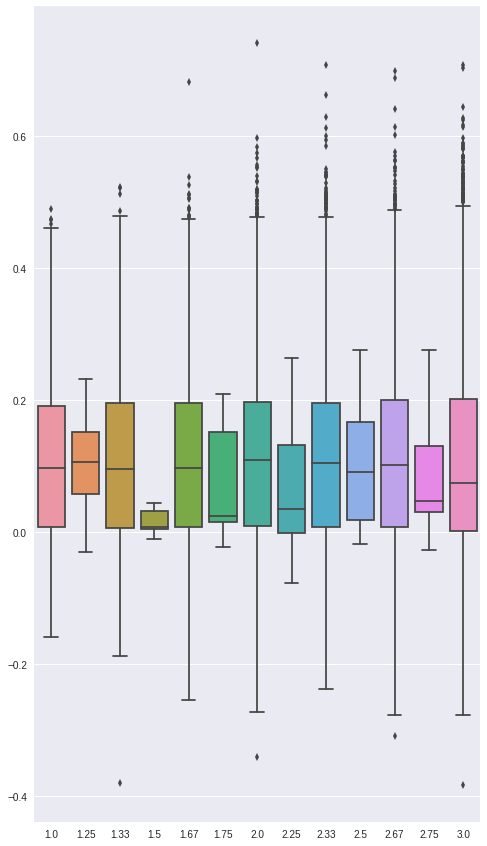

In [49]:
fig = plt.gcf()
fig.set_size_inches(8,15)
#sns.stripplot(relevance_scores,similarity_scores,jitter=True, alpha=.40)
#sns.pointplot(relevances,overlap_ratios,jitter=True, alpha=.40)
sns.boxplot(relevance_scores,avg_uidfact_all_similarity_scores)

#sns.despine()

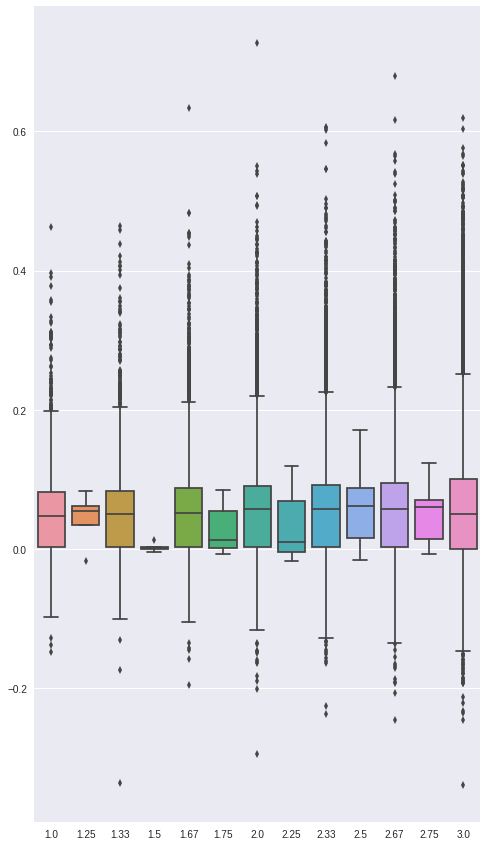

In [50]:
fig = plt.gcf()
fig.set_size_inches(8,15)
#sns.stripplot(relevance_scores,similarity_scores,jitter=True, alpha=.40)
#sns.pointplot(relevances,overlap_ratios,jitter=True, alpha=.40)
sns.boxplot(relevance_scores,avg_uidfact_keep_tag_similarity_scores)

#sns.despine()

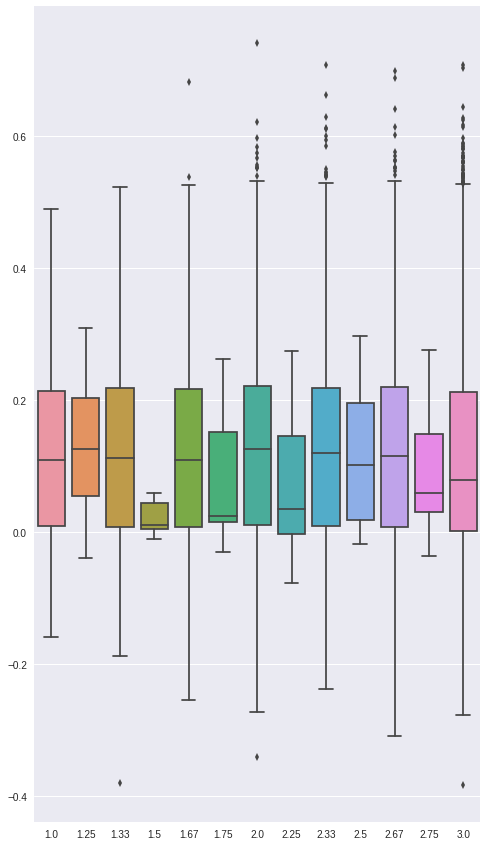

In [51]:
fig = plt.gcf()
fig.set_size_inches(8,15)
#sns.stripplot(relevance_scores,similarity_scores,jitter=True, alpha=.40)
#sns.pointplot(relevances,overlap_ratios,jitter=True, alpha=.40)
sns.boxplot(relevance_scores,avg_all_similarity_scores)

#sns.despine()

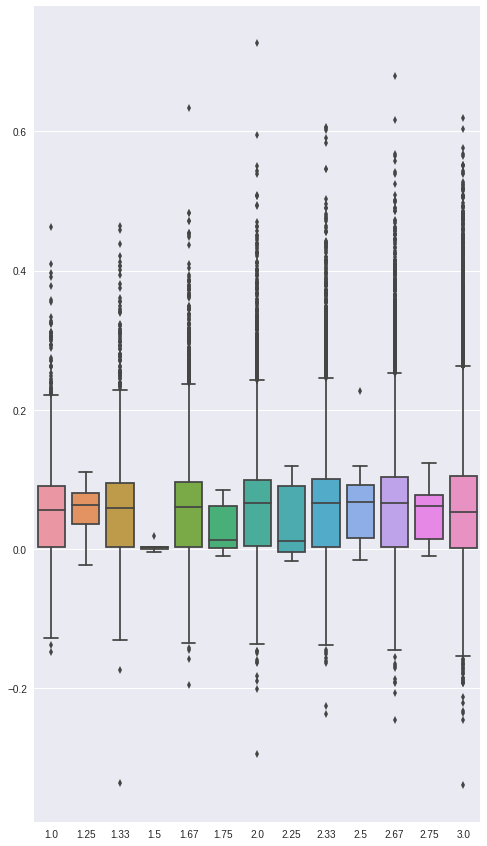

In [52]:
fig = plt.gcf()
fig.set_size_inches(8,15)
#sns.stripplot(relevance_scores,similarity_scores,jitter=True, alpha=.40)
#sns.pointplot(relevances,overlap_ratios,jitter=True, alpha=.40)
sns.boxplot(relevance_scores,avg_keep_tag_similarity_scores)

#sns.despine()

# save results

In [53]:
id_df = pd.DataFrame(train_query_df['id'],index=train_query_df.index)

In [57]:
ref_index=train_query_df.index
new_feature_df1 = pd.DataFrame(avg_all_similarity_scores,columns=['sense2vec_all_attr_simscore'],index=ref_index)
new_feature_df2 = pd.DataFrame(avg_keep_tag_similarity_scores,columns=['sense2vec_keeptag_attr_simscore'],index=ref_index)
new_feature_df3 = pd.DataFrame(avg_uidfact_all_similarity_scores,columns=['sense2vec_uidfact_all_attr_simscore'],index=ref_index)
new_feature_df4 = pd.DataFrame(avg_uidfact_keep_tag_similarity_scores,columns=['sense2vec_uidfact_keeptag_attr_simscore'],index=ref_index)
new_feature_df = pd.concat([id_df,new_feature_df1,new_feature_df2,new_feature_df3,new_feature_df4],axis=1)


In [58]:
new_feature_df

,id,sense2vec_all_attr_simscore,sense2vec_keeptag_attr_simscore,sense2vec_uidfact_all_attr_simscore,sense2vec_uidfact_keeptag_attr_simscore
0,2,-0.005017,-0.002716,-0.005017,-0.002716
1,3,-0.018247,0.003309,-0.018247,0.003309
2,9,0.269379,0.093949,0.269379,0.093949
3,16,0.199888,0.097612,0.199888,0.097612
4,17,0.183929,0.095815,0.183929,0.095815
5,18,0.054528,0.015828,0.054528,0.015828
6,20,0.308161,0.116478,0.308161,0.116478
7,21,0.209914,0.112164,0.209914,0.112164
8,23,0.034959,0.033536,0.034959,0.033536
9,27,0.251824,0.080260,0.251824,0.080260


In [59]:
pd.DataFrame(new_feature_df).to_csv('../data/features_sense2vec_simscore_attr.csv', \
                                    index=False, header=True)

In [ ]:
# save_all_similarity_scores = all_similarity_scores
# save_keep_tag_similarity_scores = keep_tag_similarity_scores
# save_avg_all_similarity_scores=avg_all_similarity_scores
# save_avg_keep_tag_similarity_scores=avg_keep_tag_similarity_scores

# concat to full features

In [11]:
feature_df = reader.getBasicDataFrame(full_features_filename)

In [12]:
feature_df

,id,product_idx,product_uid,relevance,relevance_int,search_term,color_exist,brand_exist,wm_product_description,wm_product_title,...,bm25,bm25expandedquery,len_product_title,len_product_description,len_brand,len_search_term,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,product_uid_threshold
0,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angl bracket,0,0,1.298530,1.065446,...,0.000000,0.000000,6,102,3,2,1.0,1.0,0.027027,1
1,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,0,0,1.328475,1.308964,...,0.000000,0.000000,6,102,3,2,0.0,0.0,0.000000,1
2,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck,0,0,1.296529,1.195929,...,0.000000,0.000000,12,128,4,1,8.0,3.0,0.068966,1
3,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,0,0,1.291264,1.195568,...,0.010415,0.010415,11,78,1,3,4.0,2.0,0.080000,1
4,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower faucet,0,0,1.261110,1.053995,...,0.000000,0.000000,11,78,1,2,12.0,3.0,0.240000,1
5,18,"Int64Index([3], dtype='int64')",100006,3.00,12.0,convect otr,0,0,1.309936,1.161724,...,0.010984,0.010984,12,346,1,2,4.0,2.0,0.008299,1
6,20,"Int64Index([3], dtype='int64')",100006,2.67,10.0,microwav stove,0,0,1.246113,1.136269,...,0.000000,0.000000,12,346,1,2,22.0,5.0,0.022822,1
7,21,"Int64Index([3], dtype='int64')",100006,3.00,12.0,microwav,0,0,1.303795,1.250717,...,0.000000,0.000000,12,346,1,1,5.0,4.0,0.020747,1
8,23,"Int64Index([4], dtype='int64')",100007,2.67,10.0,emerg light,0,0,1.253217,1.032900,...,0.000000,0.000000,10,103,2,2,2.0,1.0,0.035088,1
9,27,"Int64Index([5], dtype='int64')",100009,3.00,12.0,mdf 3 4,0,0,1.218341,0.855045,...,0.000000,0.000000,14,60,3,3,8.0,3.0,0.235294,1


In [64]:
copy_new_feature_df = new_feature_df.copy()
_ = copy_new_feature_df.pop('id')
copy_new_feature_df.reset_index(drop=True,inplace=True)

In [65]:
copy_new_feature_df

,sense2vec_all_attr_simscore,sense2vec_keeptag_attr_simscore,sense2vec_uidfact_all_attr_simscore,sense2vec_uidfact_keeptag_attr_simscore
0,-0.005017,-0.002716,-0.005017,-0.002716
1,-0.018247,0.003309,-0.018247,0.003309
2,0.269379,0.093949,0.269379,0.093949
3,0.199888,0.097612,0.199888,0.097612
4,0.183929,0.095815,0.183929,0.095815
5,0.054528,0.015828,0.054528,0.015828
6,0.308161,0.116478,0.308161,0.116478
7,0.209914,0.112164,0.209914,0.112164
8,0.034959,0.033536,0.034959,0.033536
9,0.251824,0.080260,0.251824,0.080260


In [ ]:
feature_df2 = pd.concat([feature_df,copy_new_feature_df],axis=1)
#copy_new_feature_df
#feature_df2 = feature_df.join(new_feature_df,on='id',how='inner',rsuffix='rid_')

#feature_df2=feature_df.set_index('id').join(feature_df2.set_index('id'),lsuffix='_')

In [ ]:
#_=feature_df2.pop('idrid_')

In [ ]:
feature_df2

In [ ]:
pd.DataFrame(feature_df2).to_csv('../data/features_full_plusnouns_pluspuidthreshpluss2vsimscorev2.csv', \
                                    index=False, header=True)

# concat to latests features

In [60]:
latest_feature_df = reader.getBasicDataFrame('../data/features_doc2vec_sense2vec_20170416.csv')

In [61]:
latest_feature_df

,id,product_idx,product_uid,relevance,relevance_int,search_term,color_exist,color1hot_almond,color1hot_aluminum,color1hot_beige,...,bm25brand,len_product_title,len_product_description,len_brand,len_search_term,sense2vec_all_simscore,sense2vec_keeptag_simscore,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore,product_uid_threshold
0,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angl bracket,0,0,0,0,...,0.000596,6,102,3,2,0.026117,-0.022627,0.026117,-0.022627,1
1,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,0,0,0,0,...,0.000000,6,102,3,2,0.159208,0.084537,0.159208,0.084537,1
2,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck,0,0,0,0,...,0.000526,12,128,4,1,0.396952,0.110782,0.396952,0.110782,1
3,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,0,0,0,0,...,0.001148,11,78,1,3,0.305971,0.155425,0.305971,0.155425,1
4,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower faucet,0,0,0,0,...,0.000000,11,78,1,2,0.359548,0.149469,0.359548,0.149469,1
5,18,"Int64Index([3], dtype='int64')",100006,3.00,12.0,convect otr,0,0,0,0,...,0.001613,12,346,1,2,0.012246,0.007444,0.012246,0.007444,1
6,20,"Int64Index([3], dtype='int64')",100006,2.67,10.0,microwav stove,0,0,0,0,...,0.000000,12,346,1,2,0.450305,0.152107,0.450305,0.152107,1
7,21,"Int64Index([3], dtype='int64')",100006,3.00,12.0,microwav,0,0,0,0,...,0.000000,12,346,1,1,0.382512,0.176739,0.382512,0.176739,1
8,23,"Int64Index([4], dtype='int64')",100007,2.67,10.0,emerg light,0,0,0,0,...,0.000783,10,103,2,2,0.236343,0.094054,0.236343,0.094054,1
9,27,"Int64Index([5], dtype='int64')",100009,3.00,12.0,mdf 3 4,0,0,0,0,...,0.001093,14,60,3,3,0.355857,0.149728,0.355857,0.149728,1


In [62]:
new_feature_df

,id,sense2vec_all_attr_simscore,sense2vec_keeptag_attr_simscore,sense2vec_uidfact_all_attr_simscore,sense2vec_uidfact_keeptag_attr_simscore
0,2,-0.005017,-0.002716,-0.005017,-0.002716
1,3,-0.018247,0.003309,-0.018247,0.003309
2,9,0.269379,0.093949,0.269379,0.093949
3,16,0.199888,0.097612,0.199888,0.097612
4,17,0.183929,0.095815,0.183929,0.095815
5,18,0.054528,0.015828,0.054528,0.015828
6,20,0.308161,0.116478,0.308161,0.116478
7,21,0.209914,0.112164,0.209914,0.112164
8,23,0.034959,0.033536,0.034959,0.033536
9,27,0.251824,0.080260,0.251824,0.080260


In [ ]:
feature_df[['id','product_uid_threshold']]

In [66]:
feature_df3 = pd.concat([latest_feature_df,copy_new_feature_df],axis=1)

# feature_df3 = latest_feature_df.join(new_feature_df,on='id',how='inner',rsuffix='rid_')
# _=feature_df3.pop('idrid_')
# feature_df3

In [ ]:
feature_df3 = pd.concat([feature_df3,feature_df['product_uid_threshold']],axis=1)

# feature_df3 = feature_df3.join(feature_df[['id','product_uid_threshold']],on='id',how='inner',rsuffix='rid_')
# _=feature_df3.pop('idrid_')
# feature_df3

In [67]:
feature_df3

,id,product_idx,product_uid,relevance,relevance_int,search_term,color_exist,color1hot_almond,color1hot_aluminum,color1hot_beige,...,len_search_term,sense2vec_all_simscore,sense2vec_keeptag_simscore,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore,product_uid_threshold,sense2vec_all_attr_simscore,sense2vec_keeptag_attr_simscore,sense2vec_uidfact_all_attr_simscore,sense2vec_uidfact_keeptag_attr_simscore
0,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angl bracket,0,0,0,0,...,2,0.026117,-0.022627,0.026117,-0.022627,1,-0.005017,-0.002716,-0.005017,-0.002716
1,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,0,0,0,0,...,2,0.159208,0.084537,0.159208,0.084537,1,-0.018247,0.003309,-0.018247,0.003309
2,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck,0,0,0,0,...,1,0.396952,0.110782,0.396952,0.110782,1,0.269379,0.093949,0.269379,0.093949
3,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,0,0,0,0,...,3,0.305971,0.155425,0.305971,0.155425,1,0.199888,0.097612,0.199888,0.097612
4,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower faucet,0,0,0,0,...,2,0.359548,0.149469,0.359548,0.149469,1,0.183929,0.095815,0.183929,0.095815
5,18,"Int64Index([3], dtype='int64')",100006,3.00,12.0,convect otr,0,0,0,0,...,2,0.012246,0.007444,0.012246,0.007444,1,0.054528,0.015828,0.054528,0.015828
6,20,"Int64Index([3], dtype='int64')",100006,2.67,10.0,microwav stove,0,0,0,0,...,2,0.450305,0.152107,0.450305,0.152107,1,0.308161,0.116478,0.308161,0.116478
7,21,"Int64Index([3], dtype='int64')",100006,3.00,12.0,microwav,0,0,0,0,...,1,0.382512,0.176739,0.382512,0.176739,1,0.209914,0.112164,0.209914,0.112164
8,23,"Int64Index([4], dtype='int64')",100007,2.67,10.0,emerg light,0,0,0,0,...,2,0.236343,0.094054,0.236343,0.094054,1,0.034959,0.033536,0.034959,0.033536
9,27,"Int64Index([5], dtype='int64')",100009,3.00,12.0,mdf 3 4,0,0,0,0,...,3,0.355857,0.149728,0.355857,0.149728,1,0.251824,0.080260,0.251824,0.080260


In [68]:
pd.DataFrame(feature_df3).to_csv('../data/features_doc2vec_sense2vec_20170417.csv', \
                                    index=False, header=True)

# prep for doc2vec

In [ ]:
sentences = []  # Initialize an empty list of sentences
query_sentences = []
doc_sentences = []

print("Parsing sentences from search string")
for query in train_query_df["sense2vec_search_term"]:
    query_sentences += [query.split()]

print("Parsing sentences from unlabeled set")
for doc in product_df['sense2vec_content_attr']:
    doc_sentences += [doc.split()]

sentences = query_sentences+doc_sentences    

In [ ]:
sentences[0:2]

In [ ]:
sentences[-3:-1]

In [ ]:
print(len(sentences))

from gensim.models import doc2vec #word2vec

documents=[]
for i,s in enumerate(sentences):
    if s:
        document={}
        document= doc2vec.LabeledSentence(words=s,tags=['SENT_'+str(i)]) 
        documents+=[document]
print(documents[-1])    

In [ ]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 100#50#300    # Word vector dimensionality                      
min_word_count = 1#5#40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 10e-5 #0 #1e-3   # Downsample setting for frequent words

#https://github.com/jhlau/doc2vec hyperparam guide

# Initialize and train the model (this will take some time)
from gensim.models import doc2vec #word2vec
print("Training model...")
# doc2vec_model = doc2vec.Doc2Vec(documents, workers=num_workers, \
#             size=num_features, min_count = min_word_count, \
#             window = context, sample = downsampling,iter=20)

# doc2vec_model = doc2vec.Doc2Vec(documents, size=300, min_count=5, window=5, \
#                             iter=30, workers=4, alpha=0.1, min_alpha=0.0001,
#                         dm_concat=1, dm=0, negative=5)

# 20:43 run
# doc2vec_model = doc2vec.Doc2Vec(documents, size=100, min_count=0, window=8, \
#                             iter=20, workers=4, #alpha=0.1, min_alpha=0.0001,
#                             dm_concat=1, dm=0,sample = 0,  negative=5,dbow_words=1)  

# # 20:57 run
# doc2vec_model = doc2vec.Doc2Vec(documents, size=100, min_count=0, window=16, \
#                             iter=20, workers=4, #alpha=0.1, min_alpha=0.0001,
#                             dm_concat=1, dm=0,sample = downsampling,  negative=5,dbow_words=1)  

#New
doc2vec_model = doc2vec.Doc2Vec(documents, size=200, min_count=1, window=10, \
                            iter=30, workers=4, #alpha=0.1, min_alpha=0.0001,
                            sample = downsampling,  negative=5,dbow_words=1,
                               dm_mean=0, dm_concat=1, dm=1,)  

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
doc2vec_model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
#model_name = "300features_40minwords_10context"
doc2vec_model.save(doc2vec_model_path)

In [ ]:
print(len(doc2vec_model.wv.vocab))
doc2vec_model.wv.vocab

In [ ]:
vocab_words=[k for k,v in doc2vec_model.wv.vocab.items()]

In [ ]:
train_query_df.iloc[0]

In [ ]:
r = re.compile("r_emote\|",flags=re.IGNORECASE)
newlist = filter(r.match, vocab_words)
print(list(newlist))

In [ ]:
print(doc2vec_model.most_similar('r_emote|NOUN', [], 3))

In [ ]:
print(doc2vec_model.docvecs.most_similar( [ doc2vec_model['r_emote|NOUN'] ] ))

In [ ]:
print(sentences[0])
print(sentences[len(train_query_df)])

In [ ]:
doc2vec_model.docvecs.most_similar(['SENT_0'])

In [ ]:
print(sentences[74067])

In [ ]:
#doc2vec_model.docvecs.similarity('SENT_17','SENT_74068')
doc2vec_model.docvecs.similarity(0,74067+11)

In [ ]:

len(train_query_df)

In [ ]:
train_query_df

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

i=0
similarity_scores=[]
relevance_scores=[]
for query_row in train_query_df.itertuples():    
    query=nlp(str(query_row.search_term)) 
    relevance=query_row.relevance
    product_uid=int(query_row.product_uid)
    #product_idx=query_row.product_idx.values[0]
    product_idx=product_df[product_df['product_uid'] == product_uid]['content_attr'].index[0] #feature_df workaround
    
    ## similarity doc
    similarity_score = doc2vec_model.docvecs.similarity(i,int(len(train_query_df)+product_idx))
    
    ### cosine
#     similarity_score=0
#     for word in query_row.sense2vec_search_term.split():
#         #print(word)
#         #print(doc2vec_model[word].reshape(-1,1).T.shape)
#         #print(doc2vec_model.docvecs[int(len(train_query_df)+product_idx)].reshape(-1,1).T.shape)
#         similarity_score += np.squeeze(cosine_similarity(doc2vec_model[word].reshape(-1,1).T,\
#                           doc2vec_model.docvecs[int(len(train_query_df)+product_idx)].reshape(-1,1).T))
# #         print(np.squeeze(cosine_similarity(doc2vec_model[word].reshape(-1,1).T,\
# #                          doc2vec_model.docvecs[int(len(train_query_df)+product_idx)].reshape(-1,1).T)))
# #       print(similarity_score)

    ### end cosine
    
    similarity_scores+=[similarity_score]
    relevance_scores+=[relevance]
    
    i+=1
    if i % 1000 == 0: #print every 100 
        print(i)
#     if i >= 10:
#         break
#     else:
#         print(relevance,similarity_score)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
fig = plt.gcf()
fig.set_size_inches(8,15)
#sns.stripplot(relevance_scores,similarity_scores,jitter=True, alpha=.40)
#sns.pointplot(relevances,overlap_ratios,jitter=True, alpha=.40)
sns.boxplot(relevance_scores,similarity_scores)

#sns.despine()

In [ ]:
# from gensim.models.word2vec import Word2Vec
# from gensim.models.word2vec import KeyedVectors
# word2vec_model = Word2Vec.load('/home/ongmin/PycharmProjects/IRDM2017/data/models/prod_content_model')


In [ ]:
#word2vec_model.wv.vocab

In [ ]:
print(doc2vec_model.most_similar('Whirlpool|ENT', [], 3))

In [ ]:
print(doc2vec_model.most_similar('wood|NOUN', [], 3))

In [ ]:
print(doc2vec_model.most_similar('kitchen|NOUN', [], 3))

In [ ]:
print(doc2vec_model.most_similar('shower|NOUN', [], 3))

In [ ]:
print(doc2vec_model.most_similar('steel|NOUN', [], 10))

In [ ]:
print(doc2vec_model.most_similar('microwave|NOUN', [], 10))

In [ ]:
print(doc2vec_model.most_similar('LED|NOUN', [], 10))

In [ ]:
words=[k for k,v in word2vec_model.wv.vocab.items()]

In [ ]:
r = re.compile("stool\|",flags=re.IGNORECASE)
newlist = filter(r.match, words)
print(list(newlist))

In [ ]:
for word in list(filter(r.match, words)):
    #print(str(word))
    print(word,word2vec_model.most_similar(word, [], 3))

In [ ]:
nlp = spacy.load('en')
nlp.vocab.load_vectors("/home/ongmin/PycharmProjects/IRDM2017/data/models/prod_content_model")

In [ ]:
from sense2vec.vectors import VectorMap
vector_map = VectorMap(300)
a=vector_map.load('/home/ongmin/PycharmProjects/IRDM2017/data/models/')

In [ ]:
model = sense2vec.load('/home/ongmin/PycharmProjects/IRDM2017/data/models/prod_content_model')

In [13]:
feature_df_attr = reader.getBasicDataFrame('../data/features_doc2vec_sense2vec_20170417.csv')

In [14]:
feature_df_attr

,id,product_idx,product_uid,relevance,relevance_int,search_term,color_exist,color1hot_almond,color1hot_aluminum,color1hot_beige,...,len_search_term,sense2vec_all_simscore,sense2vec_keeptag_simscore,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore,product_uid_threshold,sense2vec_all_attr_simscore,sense2vec_keeptag_attr_simscore,sense2vec_uidfact_all_attr_simscore,sense2vec_uidfact_keeptag_attr_simscore
0,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angl bracket,0,0,0,0,...,2,0.026117,-0.022627,0.026117,-0.022627,1,-0.005017,-0.002716,-0.005017,-0.002716
1,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,0,0,0,0,...,2,0.159208,0.084537,0.159208,0.084537,1,-0.018247,0.003309,-0.018247,0.003309
2,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck,0,0,0,0,...,1,0.396952,0.110782,0.396952,0.110782,1,0.269379,0.093949,0.269379,0.093949
3,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,0,0,0,0,...,3,0.305971,0.155425,0.305971,0.155425,1,0.199888,0.097612,0.199888,0.097612
4,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower faucet,0,0,0,0,...,2,0.359548,0.149469,0.359548,0.149469,1,0.183929,0.095815,0.183929,0.095815
5,18,"Int64Index([3], dtype='int64')",100006,3.00,12.0,convect otr,0,0,0,0,...,2,0.012246,0.007444,0.012246,0.007444,1,0.054528,0.015828,0.054528,0.015828
6,20,"Int64Index([3], dtype='int64')",100006,2.67,10.0,microwav stove,0,0,0,0,...,2,0.450305,0.152107,0.450305,0.152107,1,0.308161,0.116478,0.308161,0.116478
7,21,"Int64Index([3], dtype='int64')",100006,3.00,12.0,microwav,0,0,0,0,...,1,0.382512,0.176739,0.382512,0.176739,1,0.209914,0.112164,0.209914,0.112164
8,23,"Int64Index([4], dtype='int64')",100007,2.67,10.0,emerg light,0,0,0,0,...,2,0.236343,0.094054,0.236343,0.094054,1,0.034959,0.033536,0.034959,0.033536
9,27,"Int64Index([5], dtype='int64')",100009,3.00,12.0,mdf 3 4,0,0,0,0,...,3,0.355857,0.149728,0.355857,0.149728,1,0.251824,0.080260,0.251824,0.080260


In [15]:
feature_df_new = pd.concat([feature_df_attr,feature_df[['noun_overlap_counts','noun_uniq_overlap_counts','noun_overlap_ratios']]],axis=1)

In [16]:
feature_df_new

,id,product_idx,product_uid,relevance,relevance_int,search_term,color_exist,color1hot_almond,color1hot_aluminum,color1hot_beige,...,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore,product_uid_threshold,sense2vec_all_attr_simscore,sense2vec_keeptag_attr_simscore,sense2vec_uidfact_all_attr_simscore,sense2vec_uidfact_keeptag_attr_simscore,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios
0,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angl bracket,0,0,0,0,...,0.026117,-0.022627,1,-0.005017,-0.002716,-0.005017,-0.002716,1.0,1.0,0.027027
1,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,0,0,0,0,...,0.159208,0.084537,1,-0.018247,0.003309,-0.018247,0.003309,0.0,0.0,0.000000
2,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck,0,0,0,0,...,0.396952,0.110782,1,0.269379,0.093949,0.269379,0.093949,8.0,3.0,0.068966
3,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,0,0,0,0,...,0.305971,0.155425,1,0.199888,0.097612,0.199888,0.097612,4.0,2.0,0.080000
4,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower faucet,0,0,0,0,...,0.359548,0.149469,1,0.183929,0.095815,0.183929,0.095815,12.0,3.0,0.240000
5,18,"Int64Index([3], dtype='int64')",100006,3.00,12.0,convect otr,0,0,0,0,...,0.012246,0.007444,1,0.054528,0.015828,0.054528,0.015828,4.0,2.0,0.008299
6,20,"Int64Index([3], dtype='int64')",100006,2.67,10.0,microwav stove,0,0,0,0,...,0.450305,0.152107,1,0.308161,0.116478,0.308161,0.116478,22.0,5.0,0.022822
7,21,"Int64Index([3], dtype='int64')",100006,3.00,12.0,microwav,0,0,0,0,...,0.382512,0.176739,1,0.209914,0.112164,0.209914,0.112164,5.0,4.0,0.020747
8,23,"Int64Index([4], dtype='int64')",100007,2.67,10.0,emerg light,0,0,0,0,...,0.236343,0.094054,1,0.034959,0.033536,0.034959,0.033536,2.0,1.0,0.035088
9,27,"Int64Index([5], dtype='int64')",100009,3.00,12.0,mdf 3 4,0,0,0,0,...,0.355857,0.149728,1,0.251824,0.080260,0.251824,0.080260,8.0,3.0,0.235294


In [17]:
pd.DataFrame(feature_df_new).to_csv('../data/features_doc2vec_sense2vec_20170418.csv', \
                                    index=False, header=True)